In [1]:
import os
from glob import glob
import shutil
from pathlib import Path, PurePath
import json
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

from PIL import Image
import cv2

# Import the new library
import segmentation_models_pytorch as smp

from torchvision import transforms as T
from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
torch.manual_seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
IMAGES = './train/images'
MASKS = './train/masks'
classes_csv = './train/classes.csv'

PATCH_IMAGES_DIR = './train_patched/images'
PATCH_MASKS_DIR = './train_patched/masks'

In [4]:
def create_tiles(img, mask, size=256, threshold=0.01, min_classes=2):
    img_tensor = torch.from_numpy(img).permute(2, 0, 1)
    mask_tensor = torch.from_numpy(mask)

    img_patches = img_tensor.unfold(1, size, size).unfold(2, size, size)
    img_patches = img_patches.contiguous().view(3, -1, size, size).permute(1, 0, 2, 3)

    mask_patches = mask_tensor.unfold(0, size, size).unfold(1, size, size)
    mask_patches = mask_patches.contiguous().view(-1, size, size)

    keep_indices = []
    for i, patch in enumerate(mask_patches):
        unique_classes = torch.unique(patch)
        foreground_pixels = (patch != 0).sum().item()
        foreground_ratio = foreground_pixels / (size * size)
        
        if len(unique_classes) >= min_classes or foreground_ratio > threshold or np.random.rand() < 0.1:
            keep_indices.append(i)

    if not keep_indices:
        keep_indices.append(np.random.randint(0, len(img_patches)))

    return img_patches[keep_indices], mask_patches[keep_indices]

In [5]:
os.makedirs(PATCH_IMAGES_DIR, exist_ok=True)
os.makedirs(PATCH_MASKS_DIR, exist_ok=True)

if not os.listdir(PATCH_IMAGES_DIR):
    print("Preprocessing patches... This will only run once.")
    original_filenames = sorted([os.path.splitext(f)[0] for f in os.listdir(IMAGES)])
    
    for filename in tqdm(original_filenames, desc="Generating and Saving Patches"):
        img_path = os.path.join(IMAGES, filename + ".jpg")
        mask_path = os.path.join(MASKS, filename + "_mask.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is not None:
            mask[mask == 3] = 0

        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        img_patches, mask_patches = create_tiles(img, mask)

        for i in range(len(img_patches)):
            patch_img_np = img_patches[i].permute(1, 2, 0).numpy()
            patch_mask_np = mask_patches[i].numpy()

            save_img_path = os.path.join(PATCH_IMAGES_DIR, f"{filename}_{i}.png")
            cv2.imwrite(save_img_path, cv2.cvtColor(patch_img_np, cv2.COLOR_RGB2BGR))

            save_mask_path = os.path.join(PATCH_MASKS_DIR, f"{filename}_{i}_mask.png")
            cv2.imwrite(save_mask_path, patch_mask_np)
    print("Patch preprocessing complete.")
else:
    print("Patched data already exists. Skipping preprocessing.")

Patched data already exists. Skipping preprocessing.


In [6]:
class PorosityPatchedDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, mean, std, transform=None):
        self.img_dir = image_dir
        self.mask_dir = mask_dir
        self.x = filenames
        self.mean = mean
        self.std = std
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image_filename = self.x[idx]
        mask_filename = os.path.splitext(image_filename)[0] + "_mask.png"
        
        img_path = os.path.join(self.img_dir, image_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [7]:
def custom_collate(batch):
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    return images, masks

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, ignore_index=-100):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        loss = ((1 - pt) ** self.gamma) * -logpt
        return loss.mean()

class DiceLoss(nn.Module):
    def __init__(self, n_classes, ignore_index=None):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes
        self.ignore_index = ignore_index

    def forward(self, input, target, smooth=1e-6):
        input_soft = F.softmax(input, dim=1)
        
        if self.ignore_index is not None:
            mask = target != self.ignore_index
            target = target[mask]
            input_soft = input_soft.permute(0, 2, 3, 1)[mask.unsqueeze(-1).expand_as(input_soft.permute(0, 2, 3, 1))]
            input_soft = input_soft.reshape(-1, self.n_classes)


        target_one_hot = F.one_hot(target, num_classes=self.n_classes).float()
        
        input_flat = input_soft.contiguous().view(-1)
        target_flat = target_one_hot.contiguous().view(-1)
        
        intersection = (input_flat * target_flat).sum()
        dice_score = (2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        return 1 - dice_score

class DiceFocalLoss(nn.Module):
    def __init__(self, n_classes, weight=None, gamma=2, alpha=0.5, ignore_index=-100):
        super(DiceFocalLoss, self).__init__()
        self.alpha = alpha
        self.focal_loss = FocalLoss(weight=weight, gamma=gamma, ignore_index=ignore_index)
        self.dice_loss = DiceLoss(n_classes=n_classes, ignore_index=ignore_index)

    def forward(self, input, target):
        focal = self.focal_loss(input, target)
        dice = self.dice_loss(input, target)
        return self.alpha * focal + (1 - self.alpha) * dice


In [9]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [10]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou_per_class = []
        for c in range(n_classes):
            true_class = pred_mask == c
            true_label = mask == c
            
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [11]:
def compute_per_class_iou(preds, labels, num_classes=6):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, num_classes=6):
    train_losses, val_losses = [], []
    train_iou, val_iou = [], []
    train_acc, val_acc = [], []
    lrs = []
    min_loss = np.inf
    no_improve = 0

    model.to(device)
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        running_loss, running_iou, running_acc, total_batches = 0, 0, 0, 0

        # The loop is now simpler as the dataloader yields batched tensors directly
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            running_iou += mIoU(outputs, masks)
            running_acc += pixel_accuracy(outputs, masks)
            total_batches += 1
            lrs.append(get_lr(optimizer))

        model.eval()
        val_loss, val_iou_score, val_accuracy, val_batches = 0, 0, 0, 0
        all_class_ious = []
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                val_iou_score += mIoU(outputs, masks)
                val_accuracy += pixel_accuracy(outputs, masks)

                preds = torch.argmax(outputs, dim=1)
                for pred, true_mask in zip(preds, masks):
                    all_class_ious.append(compute_per_class_iou(pred, true_mask, num_classes))
                val_batches += 1
        
        avg_train_loss = running_loss / total_batches
        avg_val_loss = val_loss / val_batches
        avg_train_iou = running_iou / total_batches
        avg_val_iou = val_iou_score / val_batches
        avg_train_acc = running_acc / total_batches
        avg_val_acc = val_accuracy / val_batches

        train_losses.append(avg_train_loss); val_losses.append(avg_val_loss)
        train_iou.append(avg_train_iou); val_iou.append(avg_val_iou)
        train_acc.append(avg_train_acc); val_acc.append(avg_val_acc)
        
        mean_class_ious = np.nanmean(np.array(all_class_ious), axis=0)

        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train mIoU: {avg_train_iou:.4f}, Val mIoU: {avg_val_iou:.4f}, "
              f"Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f}, "
              f"LR: {lrs[-1]:.6f}, "
              f"Time: {(time.time() - epoch_start)/60:.2f} mins")

        print("\n📊 Per-class IoU (Validation):")
        for i, iou in enumerate(mean_class_ious):
            print(f"  Class {i}: IoU = {iou:.4f}")

        if avg_val_loss < min_loss:
            print(f"Validation loss decreased ({min_loss:.4f} -> {avg_val_loss:.4f}). Saving model.")
            min_loss = avg_val_loss
            no_improve = 0
            torch.save(model.state_dict(), 'model_transfer_learning.pt')
        else:
            no_improve += 1
            print(f"No improvement in validation loss for {no_improve} epochs.")
            if no_improve >= 7:
                print("Early stopping triggered.")
                break

    total_time = (time.time() - start_time) / 60
    print(f"\nTraining completed in {total_time:.2f} minutes.")
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'train_miou': train_iou, 'val_miou': val_iou, 'train_acc': train_acc, 'val_acc': val_acc, 'lrs': lrs}
    return history

In [14]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [15]:
t_train = A.Compose([A.VerticalFlip(), A.HorizontalFlip(), A.GridDistortion(p=0.2),
                     A.GaussNoise(), A.RandomBrightnessContrast((0, 0.5), (0, 0.5))])
t_val = A.Compose([A.HorizontalFlip(), A.GridDistortion(p=0.2)])

In [16]:
x_all_patches = sorted(os.listdir(PATCH_IMAGES_DIR))
x_temp, x_test = train_test_split(x_all_patches, test_size=0.10, random_state=42)
x_train, x_val = train_test_split(x_temp, test_size=0.10, random_state=42)

In [17]:
train_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_train, mean, std, t_train)
val_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_val, mean, std, t_val)
test_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_test, mean, std, t_val)

In [18]:
batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [19]:
def get_class_distribution(dataset, num_classes=6):
    class_counts = np.zeros(num_classes, dtype=int)
    for _, mask in DataLoader(dataset, batch_size=1):
        for m in mask:
            for cls in range(num_classes):
                class_counts[cls] += torch.sum(m == cls).item()
    return class_counts

train_class_counts = get_class_distribution(train_dataset)
val_class_counts = get_class_distribution(val_dataset)

print("Train class distribution:", train_class_counts)
print("Val class distribution:", val_class_counts)

Train class distribution: [155908695    407918    404416         0     79570    158121]
Val class distribution: [17386092     6933    74814        0     9855    20418]


In [20]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,
)

In [21]:
def get_class_weights_from_masks(
    masks_dir, 
    num_classes=6, 
    background_class_id=0, 
    background_weight_multiplier=0.002,
):
    class_counts = np.zeros(num_classes, dtype=np.int64)
    total_pixels = 0

    for mask_name in os.listdir(masks_dir):
        if mask_name.endswith(".png"):
            mask_path = os.path.join(masks_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if mask is not None:
                total_pixels += mask.size
                for cls in range(num_classes):
                    class_counts[cls] += np.sum(mask == cls)
    
    class_frequencies = class_counts / total_pixels
    class_frequencies[class_frequencies == 0] = 1e-6
    
    class_weights = 5.0 / class_frequencies
    
    class_weights[background_class_id] *= background_weight_multiplier
    
    class_weights = class_weights * (num_classes / np.sum(class_weights))
    
    return torch.tensor(class_weights, dtype=torch.float32)

In [22]:
class_weights = get_class_weights_from_masks(PATCH_MASKS_DIR, num_classes=6)
class_weights = class_weights.to(device)
print(f"Using class weights: {class_weights}")

Using class weights: tensor([1.2035e-08, 2.3799e-03, 2.3724e-03, 5.9778e+00, 1.1669e-02, 5.8132e-03],
       device='mps:0')


In [23]:
max_lr = 1e-3
epoch = 100
weight_decay = 1e-4

In [24]:
criterion = DiceFocalLoss(
    n_classes=6,
    weight=class_weights,
    gamma=2,
    alpha=0.5,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

In [25]:
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch 1 Training:   0%|          | 0/150 [00:00<?, ?it/s]

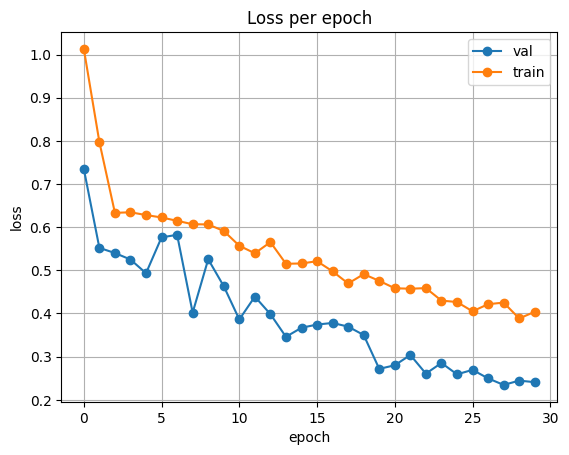

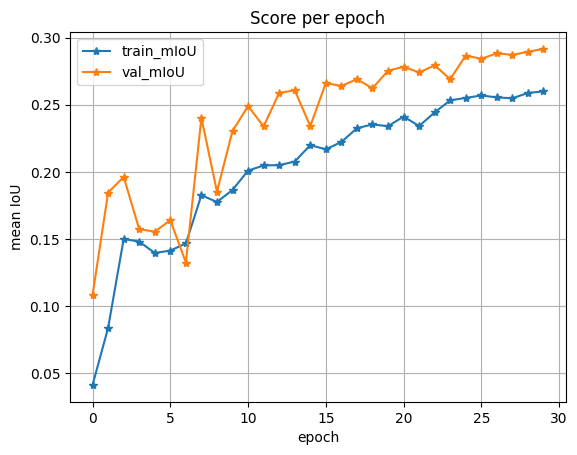

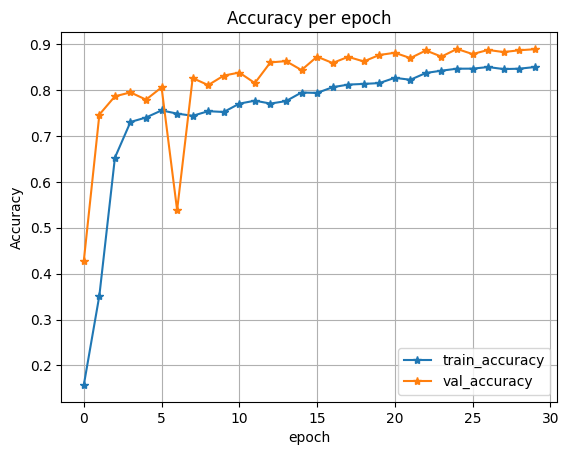

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
CLASS_COLORS = [
    [0, 0, 0],         # Class 0: Background
    [255, 0, 0],       # Class 1
    [0, 255, 0],       # Class 2
    [0, 0, 0],         # Class 3 (Now part of background)
    [255, 255, 0],     # Class 4
    [0, 255, 255],     # Class 5
]

In [ ]:
def masks_to_color_img(mask, class_colors):
    """
    Converts a grayscale mask (with class indices) to a color image.
    """
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in enumerate(class_colors):
        color_mask[mask == class_id] = color
    return color_mask

def save_and_display_predictions(model, loader, device, output_dir="test_predictions"):
    """
    Saves and displays model predictions for a given data loader.

    Args:
        model (torch.nn.Module): The trained model.
        loader (DataLoader): The DataLoader for the dataset to evaluate.
        device (torch.device): The device to run inference on.
        output_dir (str): The directory where prediction images will be saved.
    """
    print(f"Saving prediction images to '{output_dir}/'...")
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    
    # Get the mean and std used for normalization to un-normalize the images for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    file_counter = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Generating Predictions"):
            images = images.to(device)
            
            # Get model outputs and find the predicted class for each pixel
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Move data to CPU for processing with NumPy/Matplotlib
            images_cpu = images.cpu()
            masks_cpu = masks.cpu().numpy()
            preds_cpu = preds.cpu().numpy()

            for i in range(images_cpu.size(0)):
                # 1. Un-normalize the original image for visualization
                img_np = images_cpu[i].numpy().transpose(1, 2, 0) # From (C, H, W) to (H, W, C)
                img_np = (img_np * std + mean)
                img_np = np.clip(img_np, 0, 1) # Clip values to be in the valid [0, 1] range for RGB

                # 2. Get the ground truth and predicted masks
                true_mask_np = masks_cpu[i]
                pred_mask_np = preds_cpu[i]

                # 3. Convert masks to color images using the defined color map
                true_mask_color = masks_to_color_img(true_mask_np, CLASS_COLORS)
                pred_mask_color = masks_to_color_img(pred_mask_np, CLASS_COLORS)

                # 4. Create a plot to display the images side-by-side
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
                
                ax1.imshow(img_np)
                ax1.set_title("Original Image")
                ax1.axis('off')
                
                ax2.imshow(true_mask_color)
                ax2.set_title("Ground Truth Mask")
                ax2.axis('off')

                ax3.imshow(pred_mask_color)
                ax3.set_title("Predicted Mask")
                ax3.axis('off')
                
                plt.tight_layout()
                
                # 5. Save the figure
                save_path = os.path.join(output_dir, f"prediction_{file_counter}.png")
                plt.savefig(save_path)
                plt.close(fig) # Close the figure to free up memory
                
                file_counter += 1

    print(f"Finished. All {file_counter} prediction images have been saved.")

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,
)
model.load_state_dict(torch.load('model_transfer_learning.pt', map_location=device))
model.to(device)
save_and_display_predictions(model, test_loader, device=device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

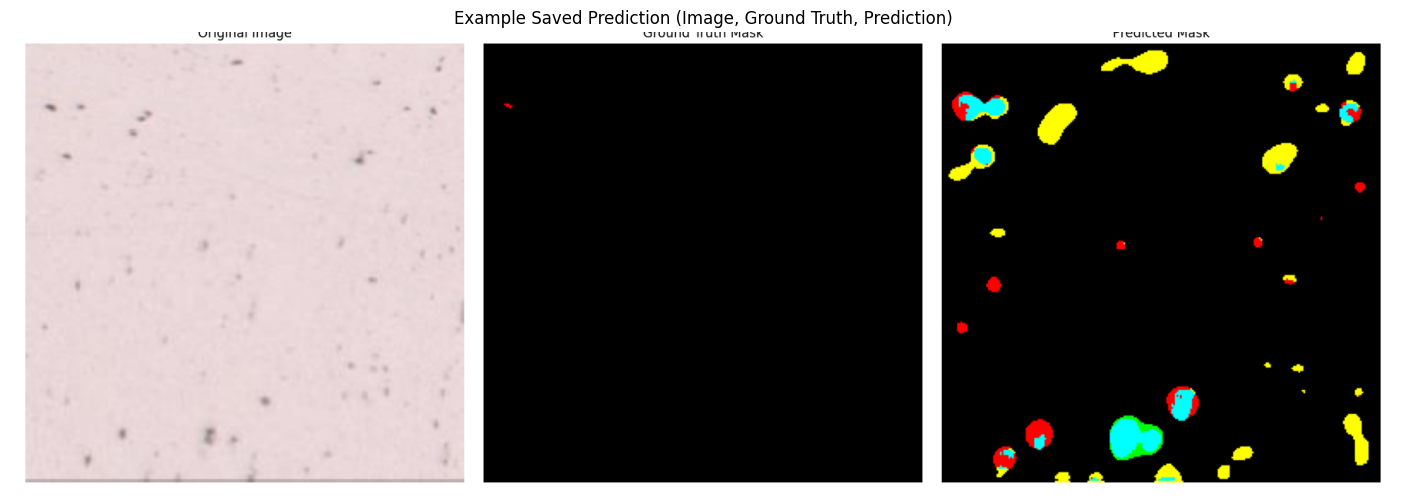

In [ ]:
try:
    first_prediction = cv2.imread('./test_predictions/prediction_0.png')
    first_prediction = cv2.cvtColor(first_prediction, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18,6))
    plt.imshow(first_prediction)
    plt.axis('off')
    plt.title("Example Saved Prediction (Image, Ground Truth, Prediction)")
    plt.show()
except Exception as e:
    print(f"Could not display example image. Error: {e}")